# Initial Exploratory Data Analysis
In this notebook some initial EDA is performed. 

Test and train sets distributions are compared and discussed.

In [1]:
import numpy as np
import pandas as pd 
from tqdm import tqdm_notebook
import os
import sys
import os.path

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import seaborn as sns
from cycler import cycler
%matplotlib inline

 
mpl.rcParams['axes.prop_cycle'] = cycler(
    'color', [
        '#0000ff', '#ff0000', '#00ffff','#ffA300', '#00ff00', '#ff00ff', 
        '#990000', '#009999', '#999900', '#009900', '#009999'
    ]
)

rc('font', size=16)
rc('text', usetex=False)
rc('figure', figsize=(14, 8))
rc('axes', linewidth=.5)
rc('lines', linewidth=1.75)

pd.options.mode.chained_assignment = None  # default='warn'

sys.path.append("../src") # Adds directory to python modules path.
from models import utils
from data import distributions
from visualization import visualize

## Load data

In [2]:
TARGET_LABEL = 'item_cnt_month'
train = utils.load_monthly_data(TARGET_LABEL)
test = utils.load_raw_data('test.csv.gz', index_col='ID')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1606541 entries, 0 to 1609123
Data columns (total 4 columns):
date_block_num    1606541 non-null int64
shop_id           1606541 non-null int64
item_id           1606541 non-null int64
item_cnt_month    1606541 non-null int32
dtypes: int32(1), int64(3)
memory usage: 55.2 MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 2 columns):
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(2)
memory usage: 4.9 MB


## Distributions analysis
Here, we will compare data distributions in train and test sets, what will be very important during model development.

In [5]:
def counts_plot(s):
    vc = s.value_counts()
    vc = vc.reindex(range(min(vc.index), max(vc.index)))
    vc.plot.bar(color='gray', figsize=(12, 8))

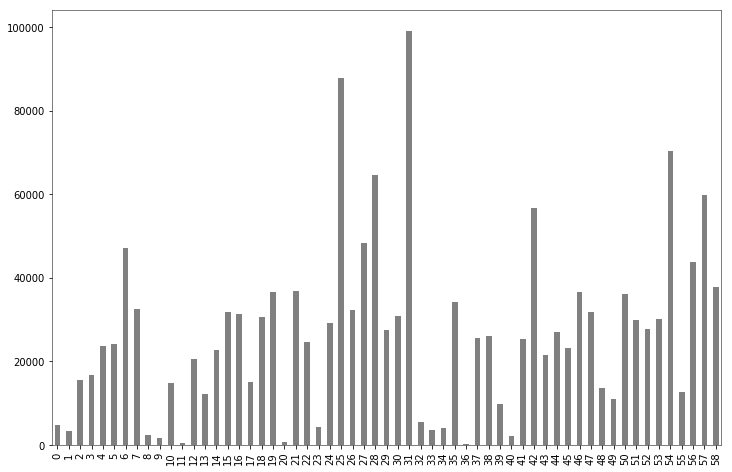

In [6]:
counts_plot(train['shop_id'])

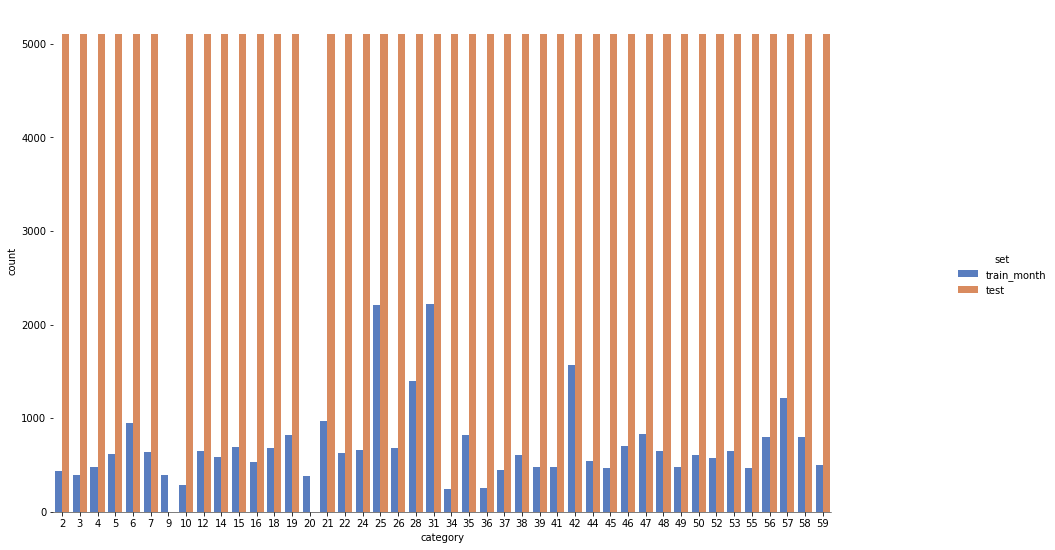

In [7]:
visualize.compare_dists(train, test)

In [8]:
test['shop_id'].value_counts().head()

59    5100
16    5100
28    5100
26    5100
25    5100
Name: test, dtype: int64

In [9]:
print(train['item_id'].nunique())
print(test['item_id'].nunique())

21805
5100


It is very interesting to see that, in test set, every shop appears either 5100 or 0 times.

Since there are exactly 5100 unique item_id in test set, it means that we have to predict value of sales for each of these unique items in each shop.

In order to have similar distributions in train and test sets, two different approaches are possible:

    1. In test set, remove any (shop_id, item_id) pair that was never seen in the past. Set its sales prediction to be zero.
    2. In train set, for each month, add rows with (shop_id, item_id) pairs that do not exist but in which given item is being sold by other shops.
    
The first approach will become more efficient due to having less data. This less data should not harm the predictive algorithm since these data are rows with pairs that were never seen in the past. To deal with those we can either set the predictions to zero or build a different model only with pairs that were never seen in the past. One the other hand, the metrics obtained in the train and validation sets will be different than the ones obtained in the Public and Private Leaderboards due to be dealing with different data distributions.

Let's start by following the first approach.

In [10]:
# Drop previous unseen pairs from each month of training set
train_red = distributions.drop_unseen_pairs(train)
# Do the same for the test set
test_red = distributions.unseen_pairs_split(train, test)[1]

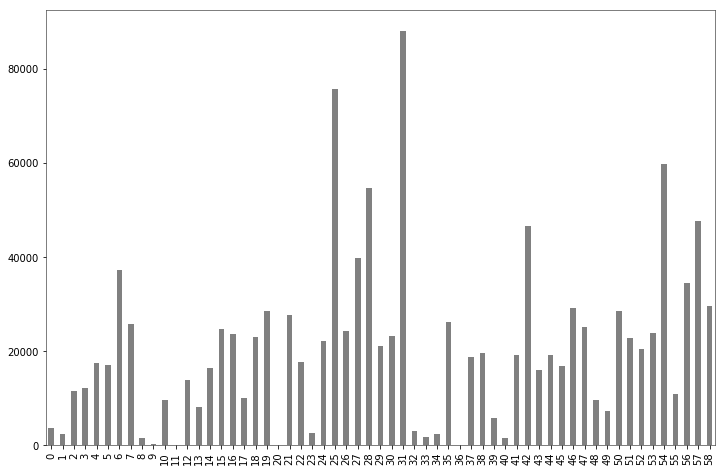

In [11]:
counts_plot(train_red['shop_id'])

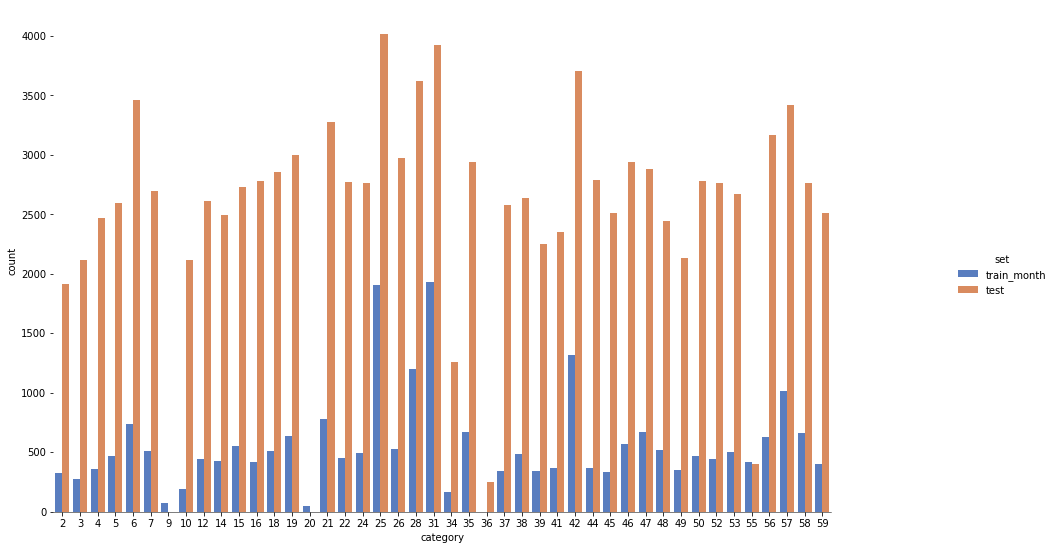

In [12]:
visualize.compare_dists(train_red, test_red)

We see that are still some differences. This time, we have much higher values for test distribution. 

This happens because some pairs in the training data have zero targets although they have appeared in the past.

To fix this, some rows must be added to the training data - pairs that have appeared in the past but that are not shown in the current month. Items that are not sold at all during month or shops that do not have any sale in that month are not included in the rows that will be added.

In [13]:
train_fix, test_fix = distributions.fix_distributions(train, test, 'item_cnt_month')

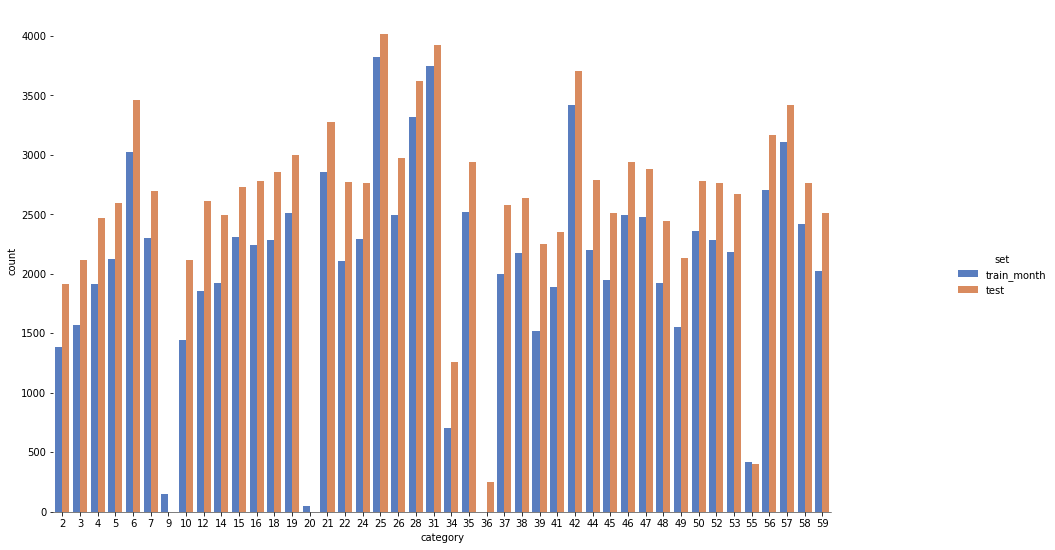

In [15]:
visualize.compare_dists(train_fix, test_fix)

We can also compare with the same month of one year ago.

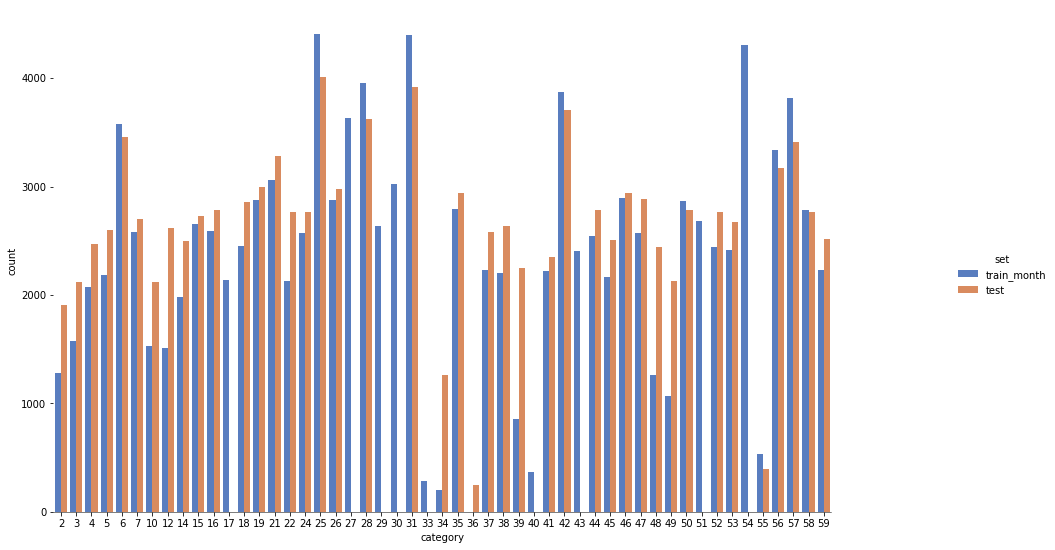

In [17]:
m = train_fix['date_block_num'].max() - 11
visualize.compare_dists(train_fix, test_fix, train_month=m)

Finnaly we have similar distributions for last month in train set and for test set.

In [18]:
train_fix2 = distributions.fix_train_distribution(train, 'item_cnt_month')

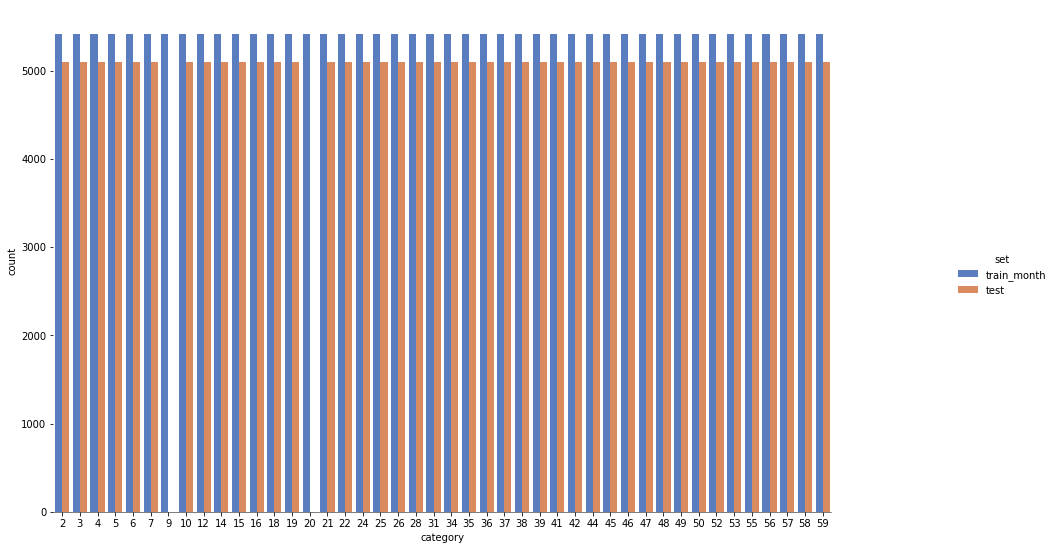

In [20]:
last_month_t = train_fix2['date_block_num'].max()
visualize.compare_dists(train_fix2, test, train_month=last_month_t)

In [23]:
train.describe()

,date_block_num,shop_id,item_id,item_cnt_month
count,1.606541e+06,1.606541e+06,1.606541e+06,1.606541e+06
mean,1.466426e+01,3.280584e+01,1.068188e+04,2.270845e+00
std,9.542351e+00,1.653645e+01,6.238702e+03,8.656355e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01
25%,6.000000e+00,2.100000e+01,5.046000e+03,1.000000e+00
50%,1.400000e+01,3.100000e+01,1.049700e+04,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.606000e+04,2.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,2.253000e+03


In [24]:
train_fix2.describe()

,date_block_num,shop_id,item_id,item_cnt_month
count,1.090693e+07,1.090693e+07,1.090693e+07,1.090693e+07
mean,1.497248e+01,3.118715e+01,1.130951e+04,3.344851e-01
std,9.495607e+00,1.734960e+01,6.210037e+03,3.418317e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01
25%,7.000000e+00,1.600000e+01,5.976000e+03,0.000000e+00
50%,1.400000e+01,3.000000e+01,1.139100e+04,0.000000e+00
75%,2.300000e+01,4.600000e+01,1.660600e+04,0.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,2.253000e+03
